# Pose Estimation Related to Emotions

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import cv2
import pandas as pd
from IPython.display import Image, display
from tools.detector import Detector
from tools.extractor import Extractor
from tools.metrics import prepare_base_skeleton, label_probabilities, segmentate, normalize_segment, normalize_skeleton, align_with

/Users/deniskrylov/Developer/PosEmotion/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

# Uncomment the line below to extract frames from the videos
# extractor.extract_frames()

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a probability of a particular emotion, calculated as $i/n$, where $i$ is an emotion label and $n$ is a total number of emotions that were detected by different annotators.

In [4]:
df = label_probabilities(df)
df.head()

,Video Tag,Clip Id,Frame Number,X,Y,Width,Height,Person Id,Happy,Sad,Fear,Neutral,Surprise,Disgust,Anger
0,aJKL0ahn1Dk,1,19532,41.965200,4.873195,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aJKL0ahn1Dk,1,19538,41.564836,4.874640,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aJKL0ahn1Dk,1,19544,41.164472,4.876086,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aJKL0ahn1Dk,1,19550,40.764108,4.877532,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aJKL0ahn1Dk,1,19556,39.646728,5.014136,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Extract Key Points

To extract keypoints, different approaches will be used such as YOLO-Pose, DeepPose and OpenPose. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

##### YOLO-Pose

In [5]:
def apply_yolo():    
    keypoints = []
    yolo_detector = Detector("models/yolo-pose.pt")

    for index, row in df.iterrows():
        try:
            result = yolo_detector.detect_poses("assets/frames/{}_{}.jpg".format(row["Video Tag"], index))
            keypoints.append(result.to_dict())
            print("Progress: {}/{}".format(index+1, len(df)))
        except:
            raise Exception("Error in detecting poses!")

    keypoints_df = pd.DataFrame(keypoints)
    keypoints_df.to_csv("/Users/deniskrylov/Developer/PosEmotion/assets/annotations/yolo_keypoints.csv", index=True)


# Uncomment the line below to apply YOLO to the frames
# apply_yolo()

yolo_df = pd.read_csv("/Users/deniskrylov/Developer/PosEmotion/assets/annotations/yolo_keypoints.csv")
yolo_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,803.315979,173.557571,835.515747,148.530548,783.055054,145.369812,879.411865,173.806686,757.570801,163.862640,...,695.001770,688.964600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,804.176758,173.216003,835.653809,147.682251,782.198486,145.796295,878.665039,173.041428,754.971069,165.978302,...,691.973938,694.487122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,805.239990,169.009888,836.457214,143.686768,782.505249,142.022675,877.768127,170.935852,753.729370,164.452728,...,695.380554,695.014038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,805.590393,172.032562,835.968811,146.862885,780.613586,146.146515,877.941833,173.451324,752.341492,171.449234,...,690.252319,686.663513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,787.117676,165.914810,817.990356,138.446503,763.025269,141.949539,868.388611,162.747101,740.108887,168.018570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



image 1/1 /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_4.jpg: 768x1280 1 person, 1095.9ms
Speed: 2.9ms preprocess, 1095.9ms inference, 287.7ms postprocess per image at shape (1, 3, 768, 1280)
Keypoints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_4.jpg
Nose: [787.11767578125, 165.91481018066406]
Left Eye: [817.9903564453125, 138.44650268554688]
Right Eye: [763.0252685546875, 141.9495391845703]
Left Ear: [868.3886108398438, 162.74710083007812]
Right Ear: [740.10888671875, 168.01856994628906]
Left Shoulder: [922.49560546875, 339.0283203125]
Right Shoulder: [670.8563232421875, 348.4941101074219]
Left Elbow: [985.5858154296875, 560.3587036132812]
Right Elbow: [603.4796752929688, 580.138916015625]
Left Wrist: [808.603515625, 491.80419921875]
Right Wrist: [569.114501953125, 465.9281311035156]
Left Hip: [None, None]
Right Hip: [None, None]
Left Knee: [None, None]
Right Knee: [None, None]
Left Ankle: [None, None]
Right Ankle: [None, None]


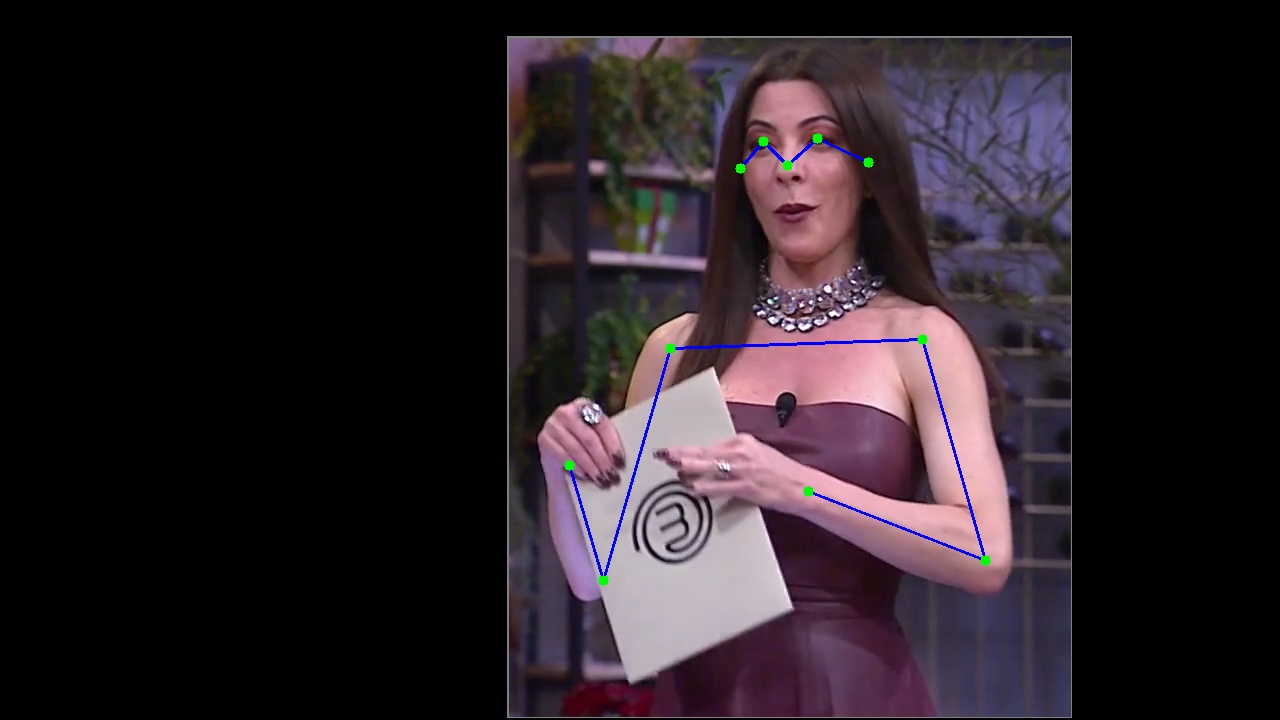

In [6]:
yolo_detector = Detector("models/yolo-pose.pt")
# result = yolo_detector.detect_poses("assets/frames/Bqb2wT_eP_4_266.jpg")
result = yolo_detector.detect_poses("assets/frames/aJKL0ahn1Dk_4.jpg")
print(result)
result.draw_ipython(False)

##### OpenPose

##### PoseFlow

### Normalization

Normalization has 2 parts: segment and frame normalization.

- Segment
    - If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
    - If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
    - If the size of a segment $s = x$, then segment normalization won't be applied.
- Skeleton
    - Use base skeleton of a human, specifically torso parts like left and right shoulders, left and right hips.
    - Calculate transformation matrix according to the base skelton from a detected human.
    - Use tranformation matrix to transform all detected points, so skeletons will have similar sizes and angles (!).

##### Segment Normalization

In [7]:
df = pd.read_csv("/Users/deniskrylov/Developer/PosEmotion/assets/annotations/yolo_annotations.csv")
segments = segmentate(df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [normalize_segment(segment) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)
norm_segments = segmentate(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 630
Original (first 5): [(0, 27), (28, 39), (40, 51), (52, 69), (70, 77)]
Total number of normalized segments: 630
Normalized (first 5): [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]


##### Skeleton Normalization


image 1/1 /Users/deniskrylov/Developer/PosEmotion/assets/base_skeleton_new.png: 768x1280 1 person, 1078.5ms
Speed: 2.4ms preprocess, 1078.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1280)
Keypoints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/base_skeleton_new.png
Nose: [632.155517578125, 120.25382995605469]
Left Eye: [643.1406860351562, 111.86296081542969]
Right Eye: [623.6358032226562, 111.27861022949219]
Left Ear: [658.3220825195312, 122.65689086914062]
Right Ear: [610.6387939453125, 120.78030395507812]
Left Shoulder: [687.4756469726562, 184.8739776611328]
Right Shoulder: [583.1585693359375, 182.85595703125]
Left Elbow: [718.5528564453125, 253.97537231445312]
Right Elbow: [549.0220336914062, 255.188232421875]
Left Wrist: [757.4696044921875, 316.7568359375]
Right Wrist: [510.50738525390625, 319.6153869628906]
Left Hip: [666.7677612304688, 336.896728515625]
Right Hip: [599.4161376953125, 335.7857666015625]
Left Knee: [676.8177490234375, 471.35888671875]


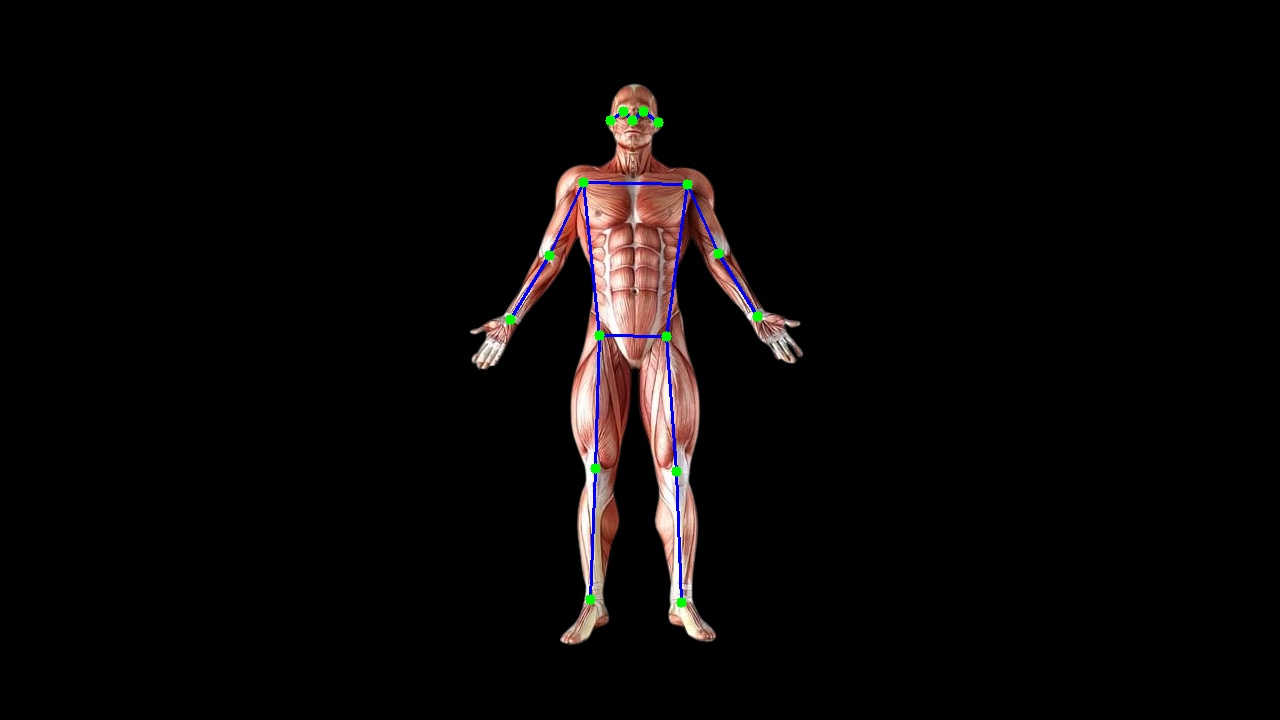

In [8]:
# Prepare base skeleton with the same image size as initial frames
base_skeleton = prepare_base_skeleton()

yolo_detector = Detector("models/yolo-pose.pt")
base_result = yolo_detector.detect_poses("assets/base_skeleton_new.png")
print(base_result)
base_result.draw_ipython(False)

Keypoints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_4.jpg
Nose: [631.07117, 120.26872]
Left Eye: [642.95874, 112.16459]
Right Eye: [623.824, 110.917046]
Left Ear: [659.2739, 122.807976]
Right Ear: [614.7461, 118.8937]
Left Shoulder: [670.0757, 186.09271]
Right Shoulder: [582.767, 178.11221]
Left Elbow: [681.9654, 265.33353]
Right Elbow: [549.1483, 255.08221]
Left Wrist: [623.9218, 233.75165]
Right Wrist: [542.3882, 214.11151]
Left Hip: [None, None]
Right Hip: [None, None]
Left Knee: [None, None]
Right Knee: [None, None]
Left Ankle: [None, None]
Right Ankle: [None, None]


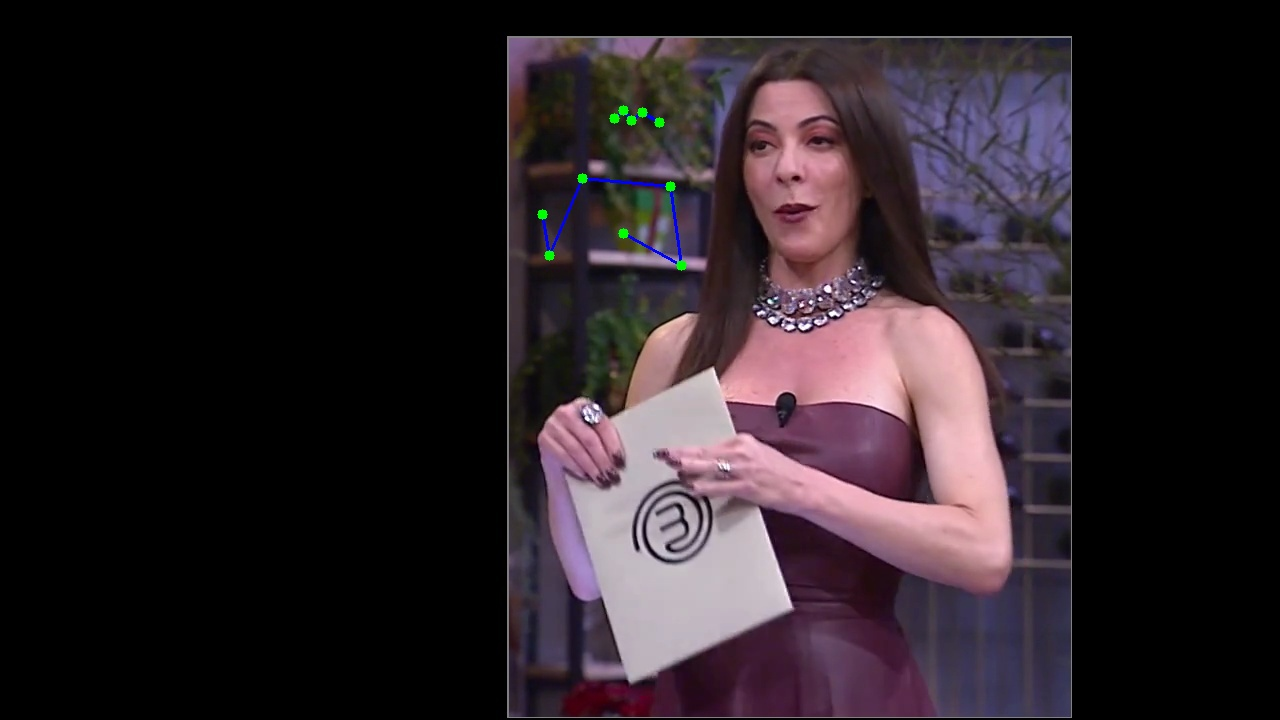

In [9]:
ks = align_with(base_result, result)
print(ks)
ks.draw_ipython(False)

Keypoints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_4.jpg
Nose: [631.07117, 120.26872]
Left Eye: [455.5872968023077, 112.16458892822266]
Right Eye: [289.00890084186983, 110.91704559326172]
Left Ear: [465.1771222551762, 122.80797576904297]
Right Ear: [283.6730563506611, 118.89369201660156]
Left Shoulder: [471.52620032063396, 186.09271240234375]
Right Shoulder: [264.87623359599934, 178.11219787597656]
Left Elbow: [478.51479620270345, 265.3335266113281]
Right Elbow: [245.11561379526583, 255.0821990966797]
Left Wrist: [444.3976364165334, 233.75164794921875]
Right Wrist: [241.14210799854894, 214.1114959716797]
Left Hip: [None, None]
Right Hip: [None, None]
Left Knee: [None, None]
Right Knee: [None, None]
Left Ankle: [None, None]
Right Ankle: [None, None]


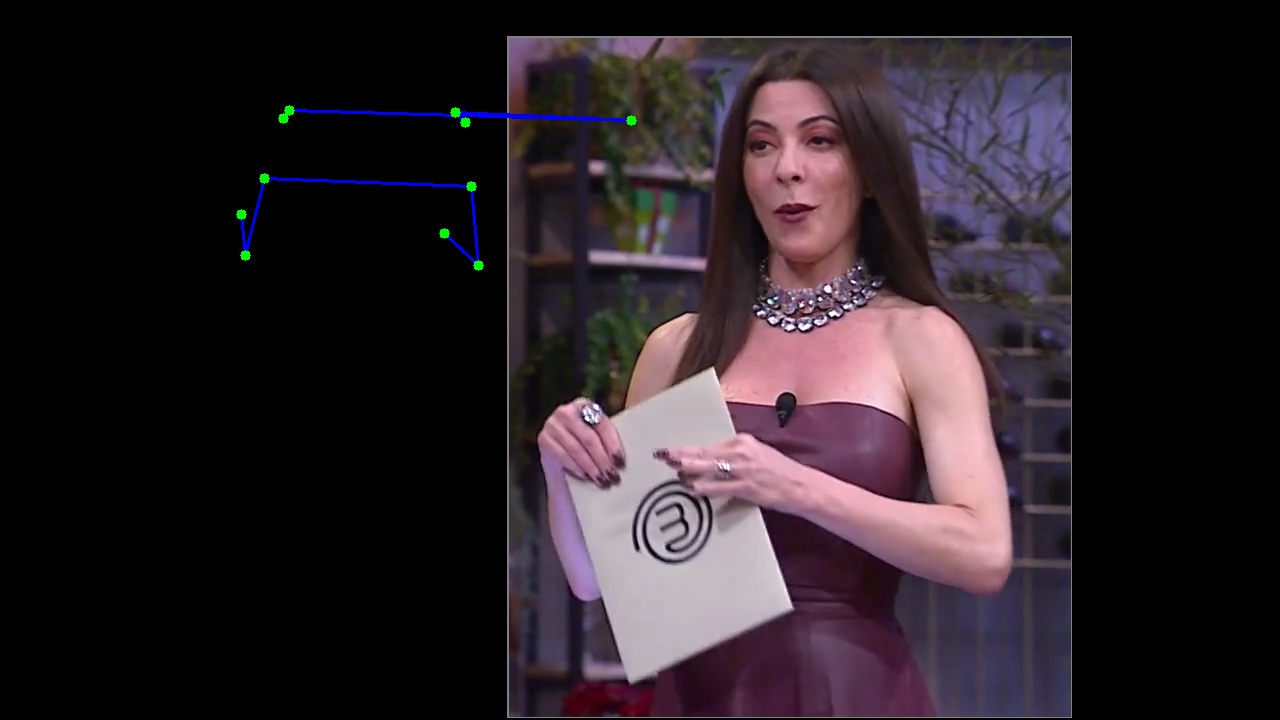

In [10]:
ksn = normalize_skeleton(ks, base_result)
print(ksn)
ksn.draw_ipython(False)

## Step 2: Feature Extraction

### Pose Features

- Trajectories can be extracted using [curve simplification (CS) method](https://www.mdpi.com/1099-4300/21/7/646).

### Dimensionality Reduction

- Principal Component Analysis

## Step 3: Clustering

### Hierarchical Clustering

## Step 4: Emotion Label Association

### Associate Poses with Emotions

## Step 5: Evaluation and Refinement

### Evaluate Clusters

### Refine Clusters